## Importación de Librerías

Comenzaremos importando las librerías necesarias para nuestro análisis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Carga de Datos

Cargamos los datos desde el archivo CSV en un DataFrame de pandas.

In [2]:
df = pd.read_csv("dataset/movies_and_tvshows.csv")

# Preprocesamiento de Datos

En esta sección, realizaremos las siguientes tareas de preprocesamiento en nuestro conjunto de datos:

1. Convertir la columna `release_date` a datetime para poder realizar análisis temporales.
2. Procesar los géneros y convertirlos en columnas individuales.
3. Convertir la columna `duration` de películas y series a minutos y número de temporadas respectivamente.
4. Almacenar determinadas variables que nos ayudarán en nuestro análisis: `genres_movies_list`, `genres_tvshows_list` y `year`


In [3]:
def min_converter_optimized(duration):
    """
    Convierte la duración en formato 'X h Y min' a minutos.
    
    Args:
    - duration (str): Duración en formato 'X h Y min' o similar.
    
    Returns:
    - int: Duración en minutos, o None si el formato no es correcto.
    """
    try:
        hours = int(re.search(r'(\d+)\s*h', duration).group(1)) * 60 if 'h' in duration else 0
        minutes = int(re.search(r'(\d+)\s*m', duration).group(1)) if 'm' in duration else 0
        return hours + minutes
    except (AttributeError, ValueError):
        return None


# Convertir fechas a datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce',format='%Y-%m-%d').dt.normalize()

# Procesamiento de géneros

# Convierte la columna 'genres' de string a lista
df['genres'] = df['genres'].apply(eval)  # Evalúa el string como una expresión de lista

# Extrae géneros únicos y crea columnas para cada género
unique_genres = set.union(*df['genres'].apply(set))
unique_genres.remove('Unknown')  # Elimina el género vacío
for genre in unique_genres:
    df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)

# Elimina la columna original 'genres'
df.drop('genres', axis=1, inplace=True)


# Conversión de duración para películas
df.loc[df['type'] == 'movie', 'duration'] = df.loc[df['type'] == 'movie', 'duration'].apply(min_converter_optimized)

# Conversión de duración para series de TV (suponiendo que es en formato 'X seasons')
df.loc[df['type'] == 'tvshow', 'duration'] = df.loc[df['type'] == 'tvshow', 'duration'].apply(lambda x: int(x.split()[0]) if x else None)


# Calcula la suma de géneros para películas y series de TV
genres_movies = df[df['type'] == 'movie'][list(unique_genres)].sum()
genres_tvshows = df[df['type'] == 'tvshow'][list(unique_genres)].sum()

# Filtra géneros con ocurrencias y convierte a listas
genres_movies_list = genres_movies[genres_movies > 0].index.tolist()  # Géneros de películas
genres_tvshows_list = genres_tvshows[genres_tvshows > 0].index.tolist()  # Géneros de series de TV


# Obtener el año de lanzamiento (mismo para todas las entradas)
year = df["release_date"].dt.year.iloc[0]

## Análisis Estadístico Inicial

Realizaremos un análisis estadístico básico para obtener una visión general de los datos. Esto incluirá un resumen estadístico de las variables numéricas, la distribución de tipos (película o serie), y un resumen de la presencia de diferentes géneros.


In [4]:
# Separamos el DataFrame en dos subconjuntos: uno para películas y otro para series de TV
movies = df[df['type'] == 'movie'].copy()
tvshows = df[df['type'] == 'tvshow'].copy()

# Calcula estadísticas descriptivas para películas
movies_stats = movies.describe().round(2)

# Calcula estadísticas descriptivas para series de TV
tvshows_stats = tvshows.describe().round(2)

# Presentamos los resultados
movies_stats, tvshows_stats



(                        release_date  metascore  user_score  weighted_score  \
 count                            484     484.00      484.00          484.00   
 mean   2023-07-11 22:18:50.578512384       6.25        6.15            6.18   
 min              2023-01-17 00:00:00       1.60        0.80            1.50   
 25%              2023-04-14 00:00:00       5.00        5.20            5.30   
 50%              2023-07-14 00:00:00       6.30        6.20            6.20   
 75%              2023-10-13 00:00:00       7.50        7.10            7.20   
 max              2023-12-30 00:00:00      10.00       10.00            9.40   
 std                              NaN       1.56        1.60            1.39   
 
          News  Family  Game-Show   Music  Action  Biography  ...  Fantasy  \
 count  484.00  484.00      484.0  484.00  484.00     484.00  ...   484.00   
 mean     0.00    0.08        0.0    0.04    0.21       0.09  ...     0.11   
 min      0.00    0.00        0.0    0.00   

## Distribución de Géneros

Calcularemos la distribución de cada género en nuestro conjunto de datos.


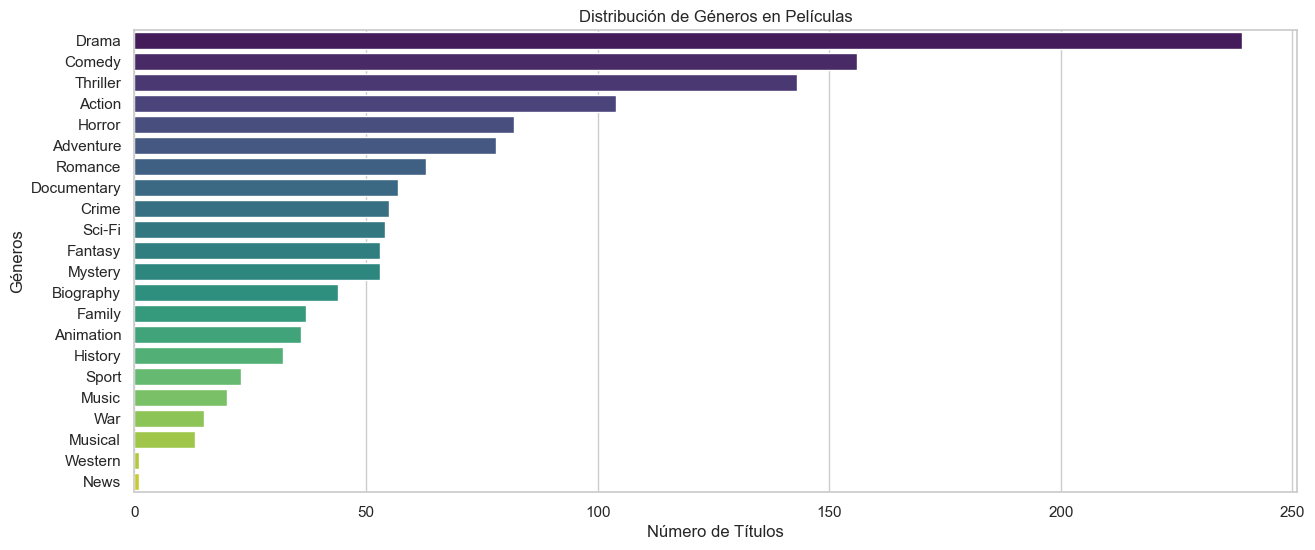

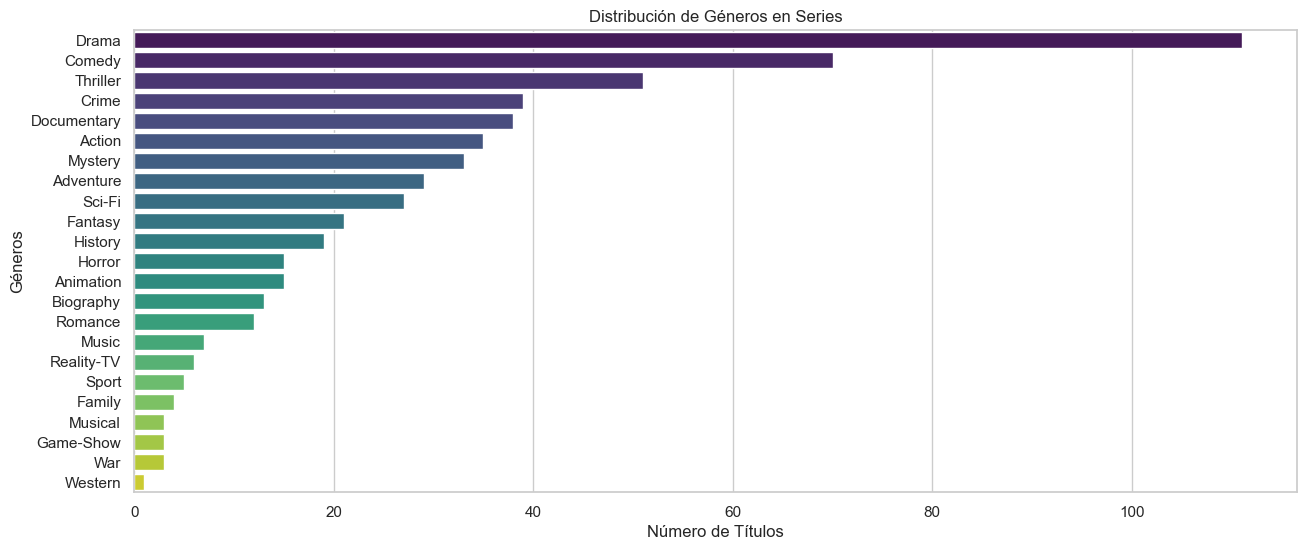

In [5]:
# Configuraciones para visualizaciones
sns.set(style="whitegrid")

# Resumen de géneros para películas y series, ordenado de mayor a menor
movies_genre_summary = movies[genres_movies_list].sum().sort_values(ascending=False)
tvshows_genre_summary = tvshows[genres_tvshows_list].sum().sort_values(ascending=False)

# Función para crear gráficos de barras para géneros
def plot_genre_distribution(genre_counts, title):
    plt.figure(figsize=(15, 6))
    sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis", hue=genre_counts.index, legend=False)
    plt.title(title)
    plt.xlabel('Número de Títulos')
    plt.ylabel('Géneros')
    plt.show()

# Gráfico de barras para géneros de películas
plot_genre_distribution(movies_genre_summary, 'Distribución de Géneros en Películas')

# Gráfico de barras para géneros de series
plot_genre_distribution(tvshows_genre_summary, 'Distribución de Géneros en Series')



# Análisis de Géneros y Calificaciones

Realizamos un análisis para entender cómo las calificaciones medias (weighted score) varían entre diferentes géneros. Este análisis puede revelar qué géneros son más populares o mejor valorados por la audiencia y los críticos.


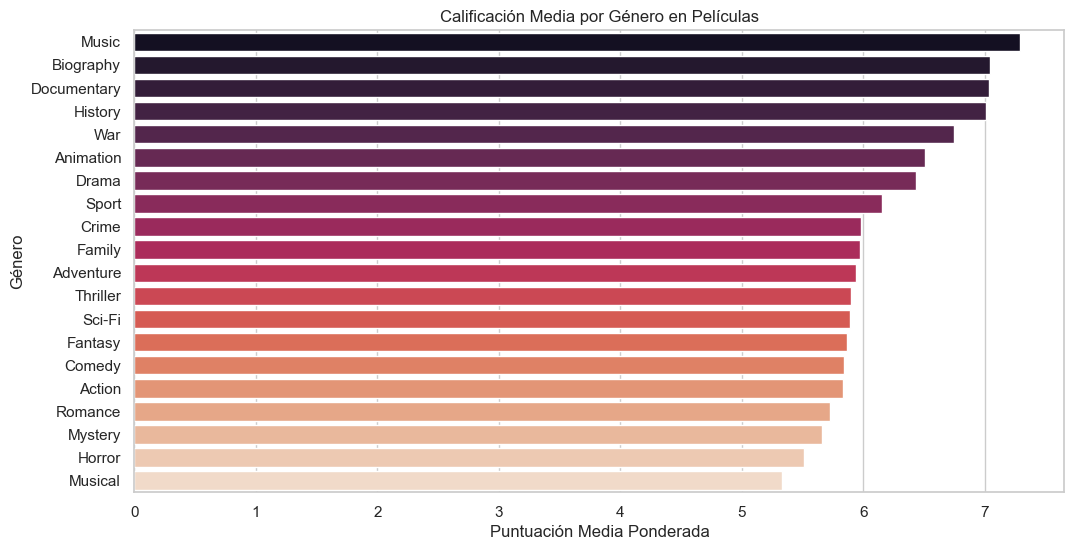

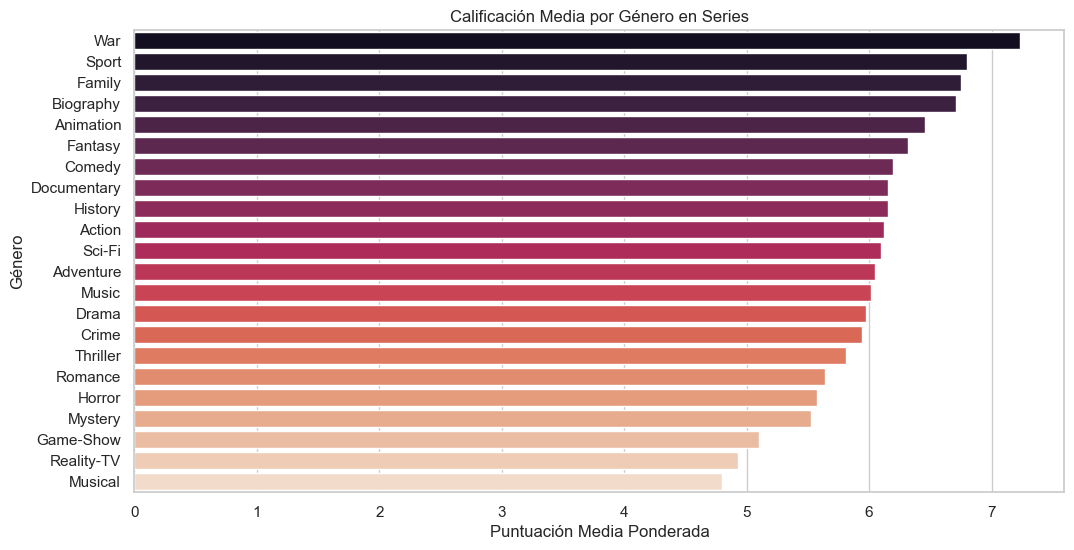

In [6]:

# Calcula las calificaciones medias para cada género en un DataFrame dado.
def calculate_genre_scores(df, genre_list, genre_summary):
    genre_scores_data = []
    for genre in genre_list:
        mean_score = df[df[genre] == 1]['weighted_score'].mean()
        if genre_summary[genre] > 1:
            genre_scores_data.append({'Genre': genre, 'Average Weighted Score': mean_score})
    return pd.DataFrame(genre_scores_data).sort_values('Average Weighted Score', ascending=False)

# Visualiza las calificaciones medias para cada género en un DataFrame dado.
def plot_genre_scores(df, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Average Weighted Score', y='Genre', data=df, palette="rocket", hue='Genre', legend=False)
    plt.title(title)
    plt.xlabel('Puntuación Media Ponderada')
    plt.ylabel('Género')
    plt.show()

# Calcular y visualizar calificaciones medias para películas
genre_scores_movies = calculate_genre_scores(movies, genres_movies_list, movies_genre_summary)
plot_genre_scores(genre_scores_movies, 'Calificación Media por Género en Películas')

# Calcular y visualizar calificaciones medias para series de TV
genre_scores_tvshows = calculate_genre_scores(tvshows, genres_tvshows_list, tvshows_genre_summary)
plot_genre_scores(genre_scores_tvshows, 'Calificación Media por Género en Series')



## Comparación de Metascores y User Scores

Utilizamos gráficos de caja para comparar la distribución de Metascores y User Scores entre películas y series.

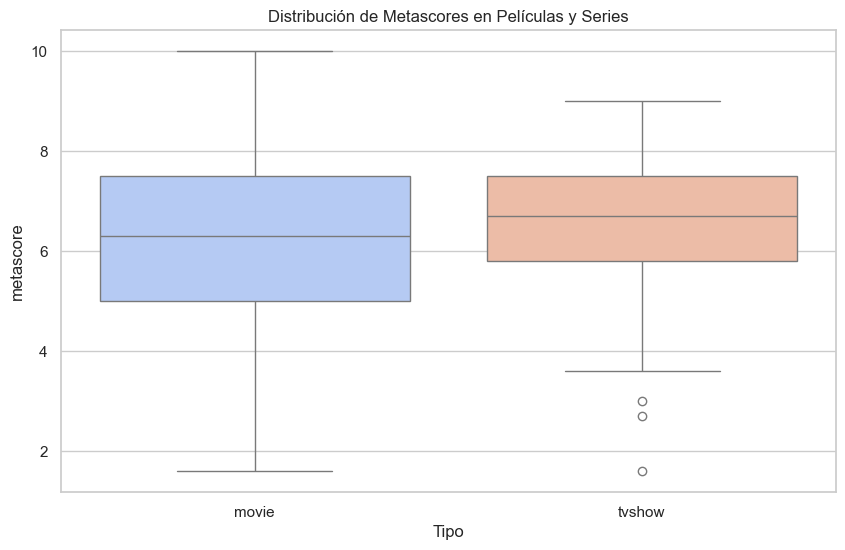

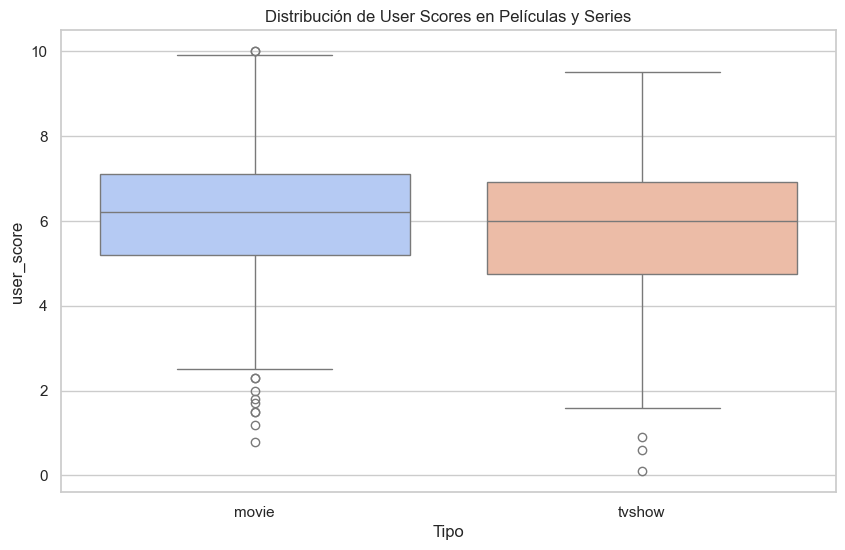

In [7]:
# Función para crear gráficos de caja
def plot_boxplot(data, column, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='type', y=column, data=data, palette="coolwarm", hue='type', legend=False, showfliers=True)
    plt.title(title)
    plt.xlabel('Tipo')
    plt.ylabel(column)
    plt.show()

# Gráficos de caja para Metascores y User Scores
plot_boxplot(df, 'metascore', 'Distribución de Metascores en Películas y Series')
plot_boxplot(df, 'user_score', 'Distribución de User Scores en Películas y Series')



# Análisis Temporal 

Hemos analizado la distribución de lanzamientos de películas y series a lo largo del año. El objetivo es identificar si hay meses específicos con una mayor cantidad de lanzamientos, lo que podría indicar períodos de alta actividad en la industria del entretenimiento.


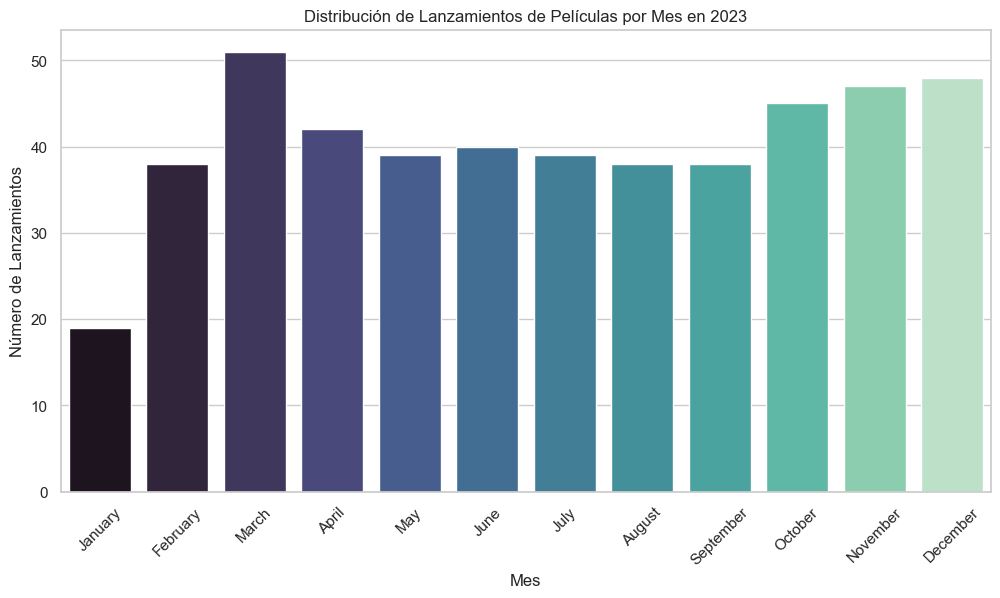

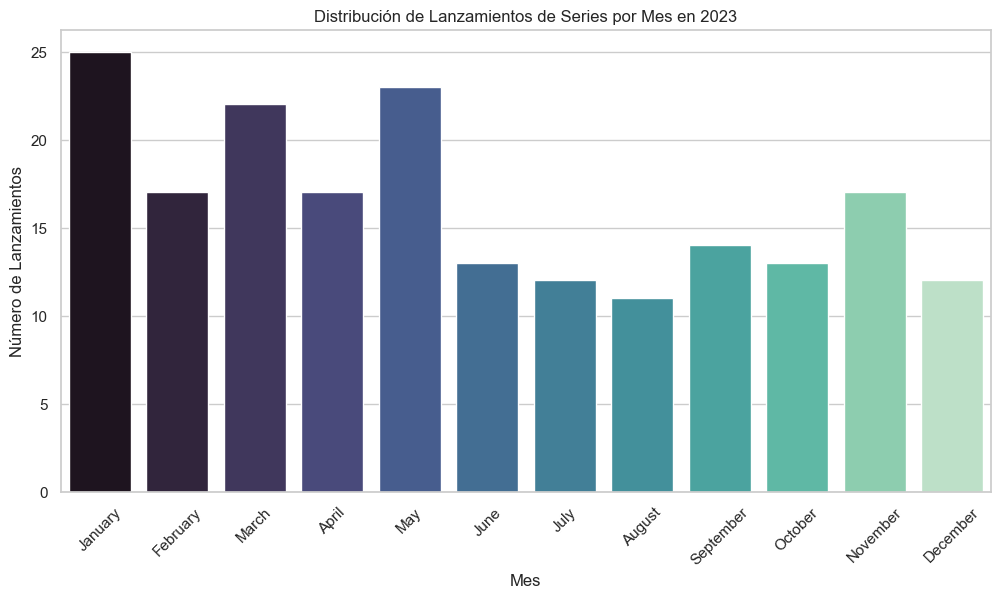

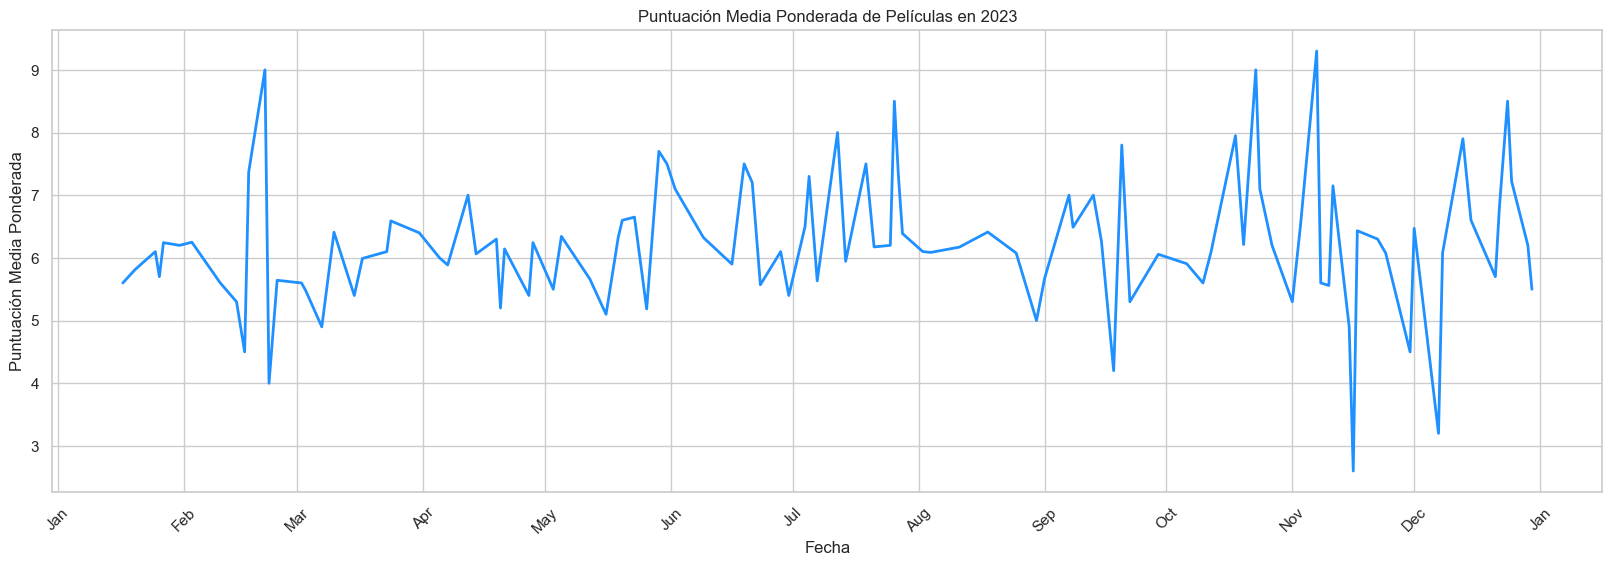

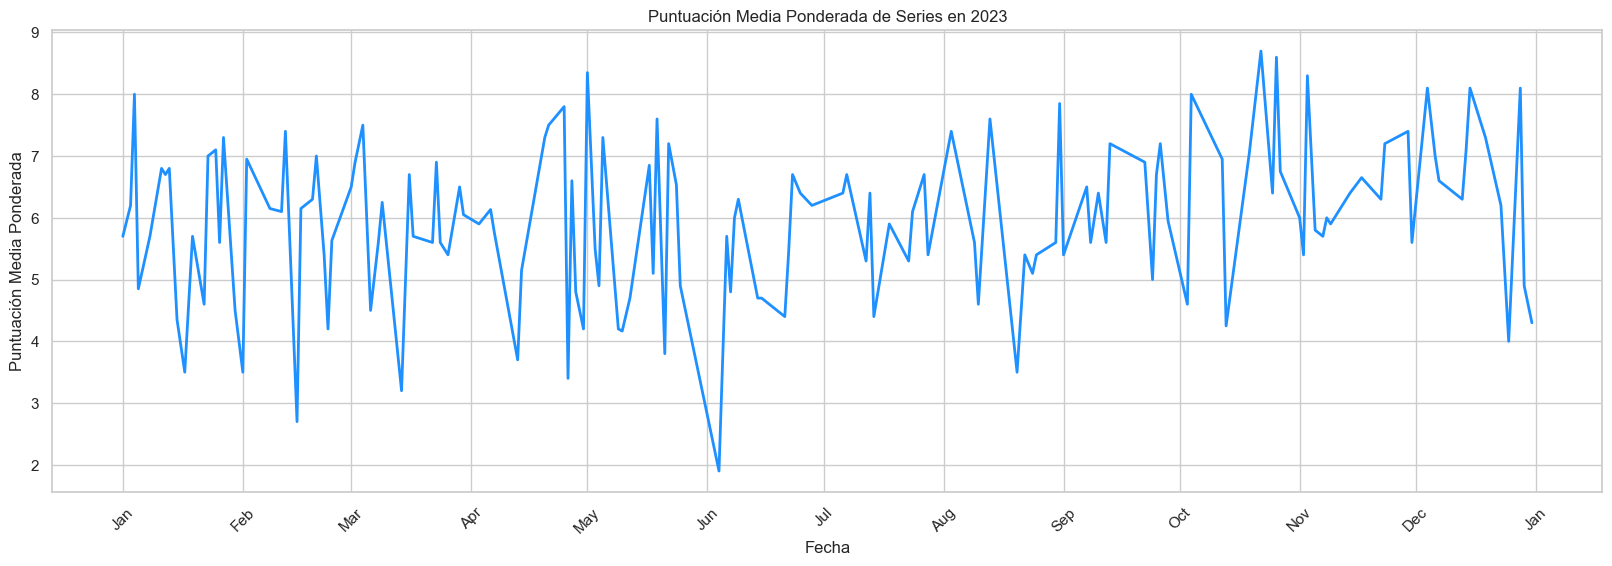

In [8]:
import matplotlib.dates as mdates

# Función para agregar y contar lanzamientos por mes
def add_month_and_count(df):
    df['month'] = df['release_date'].dt.month_name()
    return df['month'].value_counts().reindex([
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'])

# Función para crear gráficos de conteo mensual
def plot_monthly_releases(release_counts, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=release_counts.index, y=release_counts.values, palette="mako", hue=release_counts.index, legend=False)
    plt.xticks(rotation=45)
    plt.xlabel('Mes')
    plt.ylabel('Número de Lanzamientos')
    plt.title(title)
    plt.show()

# Función para crear gráficos de líneas para puntuaciones promedio
def plot_average_scores(data, title):
    plt.figure(figsize=(20, 6))
    plt.plot(data.index, data['weighted_score'], marker='', color='dodgerblue', linewidth=2)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(rotation=45)
    plt.xlabel('Fecha')
    plt.ylabel('Puntuación Media Ponderada')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Procesamiento y visualización
movie_monthly_releases = add_month_and_count(movies)
tvshows_monthly_releases = add_month_and_count(tvshows)

plot_monthly_releases(movie_monthly_releases, f'Distribución de Lanzamientos de Películas por Mes en {year}')
plot_monthly_releases(tvshows_monthly_releases, f'Distribución de Lanzamientos de Series por Mes en {year}')

# Crear un nuevo DataFrame para análisis temporal detallado
temporal_data_movies = movies[['release_date', 'weighted_score']].copy()
temporal_data_tvshows = tvshows[['release_date', 'weighted_score']].copy()

# Crear un DataFrame para el análisis temporal
daily_data_movies = temporal_data_movies.groupby(temporal_data_movies['release_date']).mean()
daily_data_tvshows = temporal_data_tvshows.groupby(temporal_data_tvshows['release_date']).mean()

plot_average_scores(daily_data_movies, f'Puntuación Media Ponderada de Películas en {year}')
plot_average_scores(daily_data_tvshows, f'Puntuación Media Ponderada de Series en {year}')



# Análisis de Correlaciones

Realizamos un análisis de correlación para explorar las relaciones entre el 'weighted score' y otras variables numéricas como la duración, metascore y user score. Este análisis puede ayudar a identificar qué factores están más fuertemente asociados con las altas calificaciones.

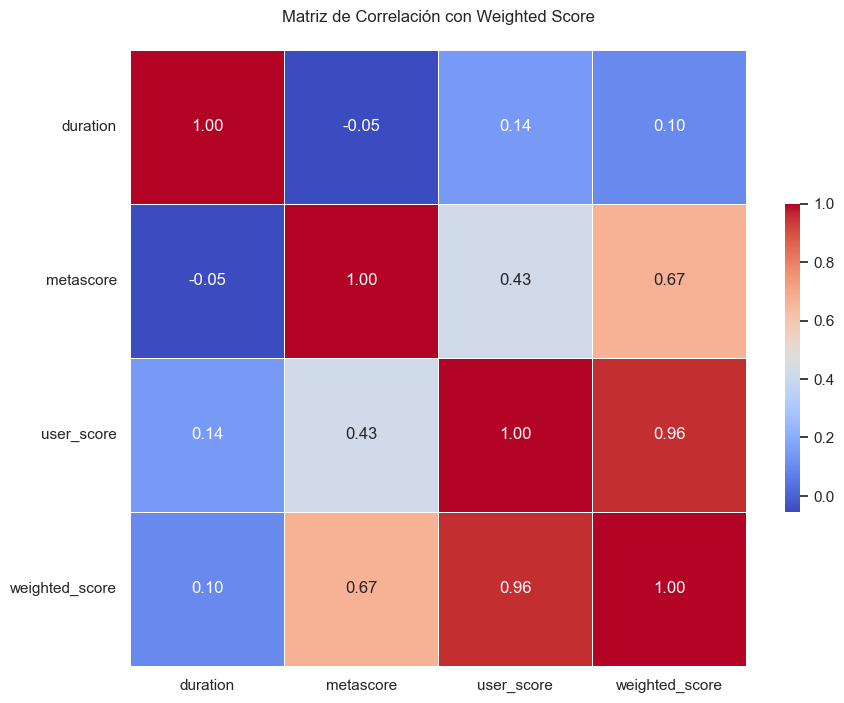

In [9]:
# Asegúrate de que 'correlation_data' contenga las columnas 'duration', 'metascore', 'user_score', 'weighted_score'
correlation_data = df[['duration', 'metascore', 'user_score', 'weighted_score']].apply(pd.to_numeric, errors='coerce')

# Calcular la matriz de correlación
correlation_matrix = correlation_data.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Matriz de Correlación con Weighted Score', pad=20)
plt.show()
